In [ ]:
# Установка зависимостей
!pip install "networkx==2.3" "decorator==4.3.0" "numpy<1.24" mordred[full] rdkit-pypi

### Расчет корреляций и понижение размерности

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import requests
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

Получшенный вами датасет с практики, как и датасет с минитаска 2, будет использоваться для выполнения минитаска 3, после завтрашней лекции про машинное обучение.

Всего записей из ChEMBL: 713
Исходное количество строк: 713
После фильтрации по Ki и nM: 713 (уменьшилось на 0)
После удаления строк без MOL/Ki: 699
После расчета дескрипторов: 699 строк
Колонки после RDKit-дескрипторов (210):
['MOL', 'pValue', 'MaxEStateIndex', 'MinEStateIndex', 'MaxAbsEStateIndex', 'MinAbsEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PE

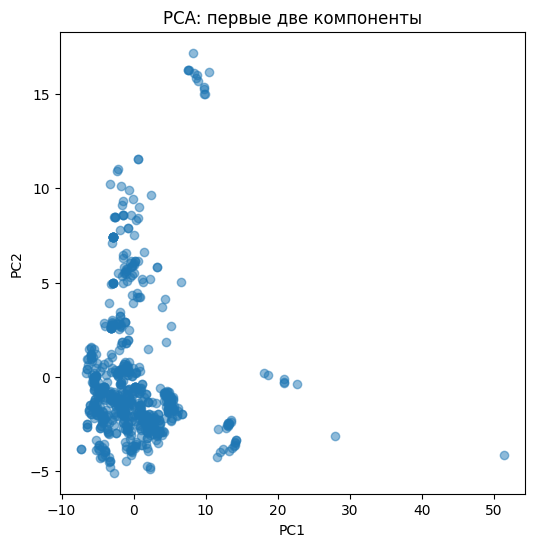

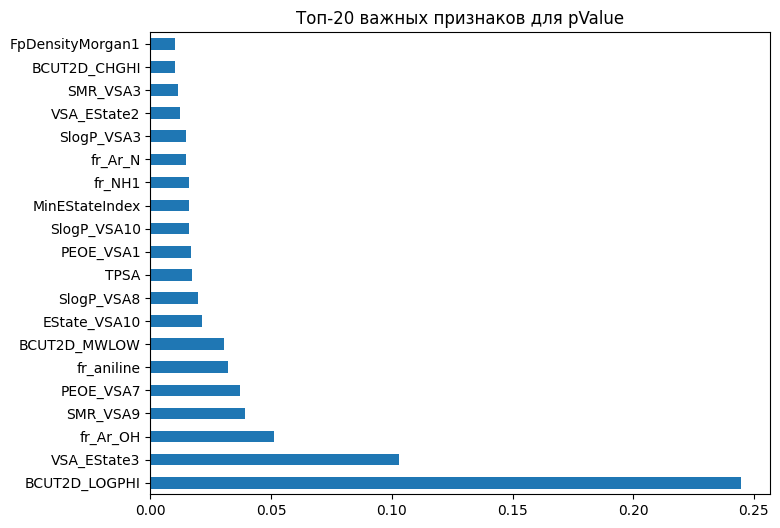

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


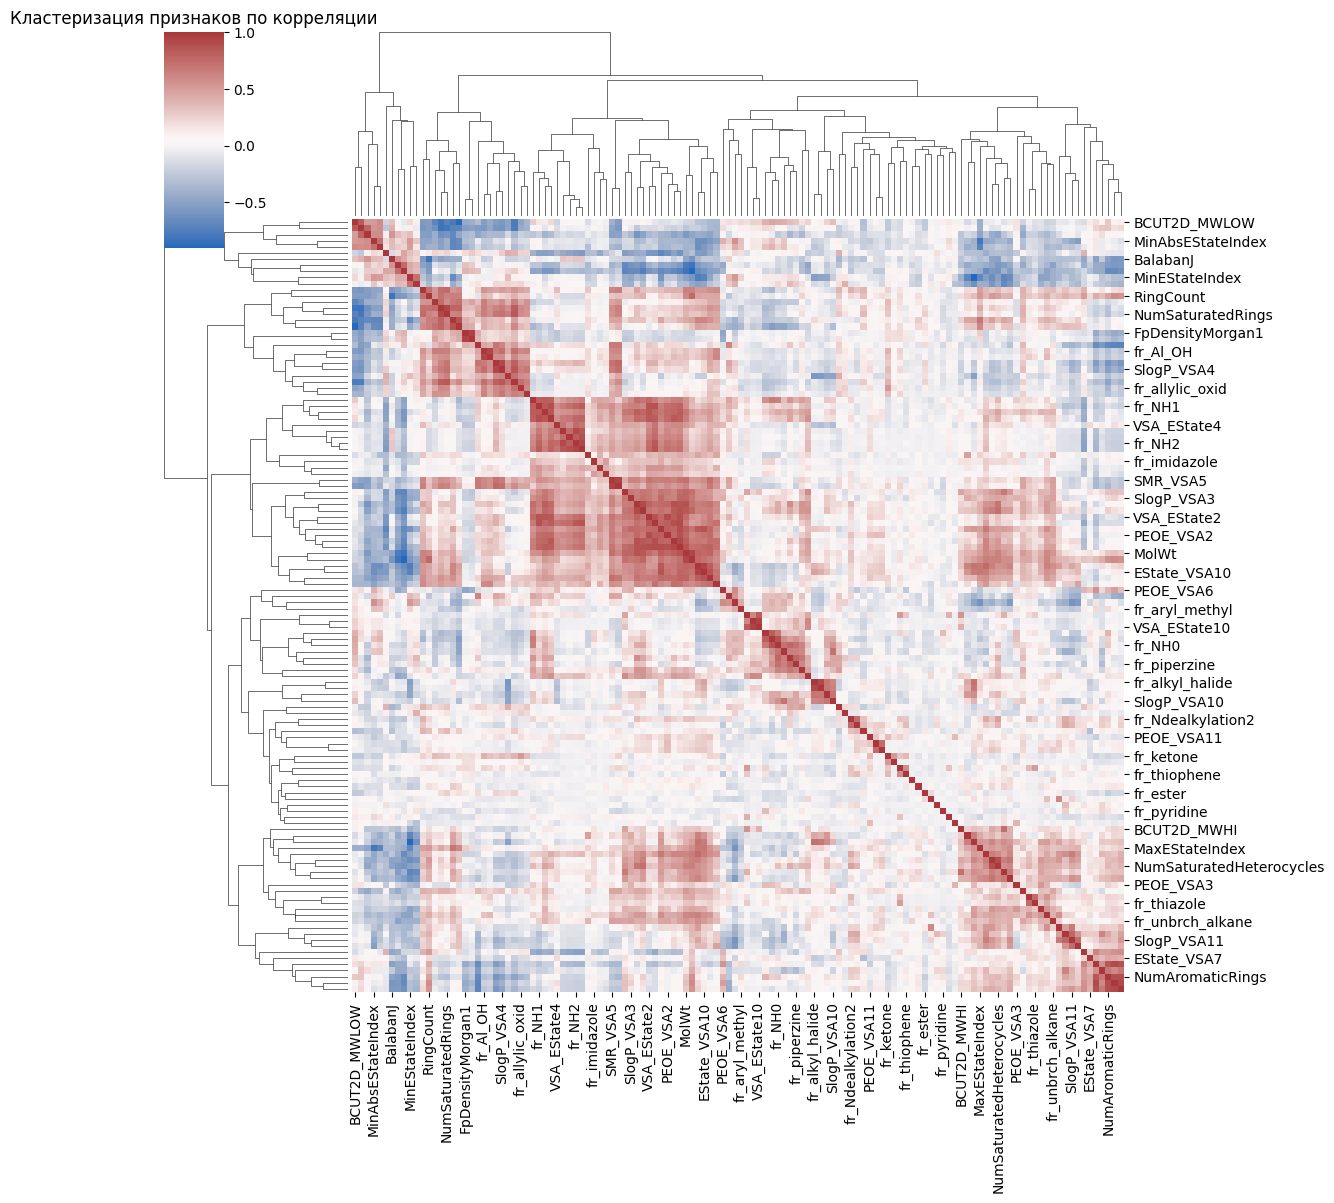

"\n# 8. Удаляем строки, где есть NaN/inf/extreme\nbefore = X.shape[0]\nmask = (~X.isnull().any(axis=1)) & (~np.isinf(X).any(axis=1)) & ((np.abs(X) < extreme).all(axis=1))\nX = X[mask]\ny = df_rdkit.loc[X.index, 'pValue']\nafter = X.shape[0]\nif after < before:\n    print(f'\nПосле удаления строк с NaN/inf/extreme: {after} (уменьшилось на {before-after})')\nelse:\n    print(f'\nПосле удаления строк с NaN/inf/extreme: {after} (строк не изменилось)')\nprint(f'Колонки: {list(X.columns)}')\n\n# 9. Заполняем оставшиеся NaN медианой (на всякий случай)\nX = X.fillna(X.median())\nprint(f'\nПосле заполнения NaN медианой: {X.shape[0]} строк, {X.shape[1]} признаков')\nprint(f'Колонки: {list(X.columns)}')\n"

In [ ]:


# 1. Загрузка данных ChEMBL по Ki для эстрогенового альфа-рецептора
url = ("https://www.ebi.ac.uk/chembl/api/data/activity.json?"
       "target_chembl_id=CHEMBL206&standard_type=Ki&standard_units=nM&limit=10000")
resp = requests.get(url)
data = resp.json()['activities']
print(f'Всего записей из ChEMBL: {len(data)}')
df = pd.DataFrame(data)

# 2. Оставляем только RowMol (если есть) или SMILES и pValue
mol_col = 'RowMol' if 'RowMol' in df.columns else 'canonical_smiles'
df = df[df[mol_col].notna() & df['standard_value'].notna()]
df['Ki_nM'] = pd.to_numeric(df['standard_value'], errors='coerce')
df = df[df['Ki_nM'] > 0]
df['pValue'] = 9 - np.log10(df['Ki_nM'])
df = df[[mol_col, 'pValue']].rename(columns={mol_col: 'MOL'})
print(f'После удаления строк без MOL/Ki: {len(df)}')

# 3. Расчет всех дескрипторов RDKit (без проверки валидности)
desc_names = [d[0] for d in Descriptors._descList]
calc = MoleculeDescriptors.MolecularDescriptorCalculator(desc_names)

desc_data = []
for mol_repr in df['MOL']:
    mol = None
    # Пробуем сначала как molblock, потом как SMILES
    try:
        mol = Chem.MolFromMolBlock(mol_repr, sanitize=True)
    except Exception:
        mol = None
    if mol is None:
        try:
            mol = Chem.MolFromSmiles(mol_repr)
        except Exception:
            mol = None
    # Если молекула невалидна, дескрипторы будут NaN
    if mol is not None:
        vals = calc.CalcDescriptors(mol)
        desc_data.append(vals)
    else:
        desc_data.append([np.nan]*len(desc_names))

df_desc = pd.DataFrame(desc_data, columns=desc_names)
df_rdkit = df.reset_index(drop=True).join(df_desc)
print(f'После расчета дескрипторов: {len(df_rdkit)} строк')
print(f'Колонки после RDKit-дескрипторов ({len(df_rdkit.columns)}):')
print(list(df_rdkit.columns))

# 4. Постобработка дескрипторов
X = df_rdkit.drop(columns=['MOL', 'pValue'])
print(f'\nНачальная размерность признаков: {X.shape}, строк: {X.shape[0]}')
print(f'Колонки: {list(X.columns)}')

# 5. Удаляем нечисловые признаки (на всякий случай)
X = X.select_dtypes(include=[np.number])
print(f'\nПосле удаления нечисловых признаков: {X.shape[0]} строк, {X.shape[1]} признаков')
print(f'Колонки: {list(X.columns)}')

# 6. Удаляем признаки, где есть хотя бы один inf, -inf, NaN или экстремум
extreme = 1e6
bad_cols = []
for col in X.columns:
    if (np.isnan(X[col]).any() or np.isinf(X[col]).any() or (np.abs(X[col]) > extreme).any()):
        bad_cols.append(col)
X = X.drop(columns=bad_cols)
print(f'\nПосле удаления признаков с NaN/inf/extreme: {X.shape[0]} строк, {X.shape[1]} признаков')
print(f'Колонки: {list(X.columns)}')

# 7. Удаляем константные признаки
selector = VarianceThreshold(threshold=0.01)
X_var = selector.fit_transform(X)
selected_cols = X.columns[selector.get_support()]
X_var = pd.DataFrame(X_var, columns=selected_cols, index=X.index)
print(f'\nПосле VarianceThreshold: {X_var.shape[0]} строк, {X_var.shape[1]} признаков')
print(f'Колонки: {list(X_var.columns)}')

# 8. Удаляем высоко коррелированные признаки
corr = X_var.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X_uncorr = X_var.drop(columns=to_drop)
print(f'\nПосле удаления коррелированных признаков: {X_uncorr.shape[0]} строк, {X_uncorr.shape[1]} признаков')
print(f'Колонки: {list(X_uncorr.columns)}')

# 9. Масштабируем и PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_uncorr)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print(f'\nПосле PCA: {X_pca.shape[0]} строк, 2 компоненты')

plt.figure(figsize=(6,6))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.5)
plt.title('PCA: первые две компоненты')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# 10. Важность признаков (RandomForest)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_uncorr, y)
importances = pd.Series(rf.feature_importances_, index=X_uncorr.columns)
top_features = importances.sort_values(ascending=False).head(20)
plt.figure(figsize=(8,6))
top_features.plot(kind='barh')
plt.title('Топ-20 важных признаков для pValue')
plt.show()

# 11. Кластеризация по корреляции
sns.clustermap(X_uncorr.corr(), cmap='vlag', figsize=(12,12))
plt.title('Кластеризация признаков по корреляции')
plt.show()
'''
# 8. Удаляем строки, где есть NaN/inf/extreme
before = X.shape[0]
mask = (~X.isnull().any(axis=1)) & (~np.isinf(X).any(axis=1)) & ((np.abs(X) < extreme).all(axis=1))
X = X[mask]
y = df_rdkit.loc[X.index, 'pValue']
after = X.shape[0]
if after < before:
    print(f'\nПосле удаления строк с NaN/inf/extreme: {after} (уменьшилось на {before-after})')
else:
    print(f'\nПосле удаления строк с NaN/inf/extreme: {after} (строк не изменилось)')
print(f'Колонки: {list(X.columns)}')

# 9. Заполняем оставшиеся NaN медианой (на всякий случай)
X = X.fillna(X.median())
print(f'\nПосле заполнения NaN медианой: {X.shape[0]} строк, {X.shape[1]} признаков')
print(f'Колонки: {list(X.columns)}')
'''